In [9]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
import sklearn
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
obs_col = 'sample'


In [4]:
# ics = od+expand(config['lr']['cerberus']['ics'], species='human')[0]
# ics = od+expand(config['lr']['talon']['ics'], species='human')[0]
talon_gtf = od+expand(config['lr']['talon']['gtf'], species='human')[0]
talon_filt_ab = od+expand(config['lr']['talon']['filt_ab'], species='human')[0]
ref_gtf = od+expand(config['ref']['gtf'], species='human')[0]
ref_ics = od+expand(config['ref']['cerberus']['ics'], species='human')[0]


In [5]:
def add_ss_type_to_intron(df):
    """
    Given a bed-style df, add "ss_3" and "ss_5" columns to 
    indicate which splice site each coordinate is used
    
    Parameters:
        df (pandas DataFrame): Bed-style DF of introns
    
    Returns:
        df (pandas DataFrame): Bed-style DF of introns w/ ss_3 and ss_5 columns added
    """
    
    df['ss_5'] = np.nan
    df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
    df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)
    
    df['ss_3'] = np.nan
    df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
    df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)
        
    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0
    
    return df
    

def intron_to_ss(df, id_cols=None):
    """
    Get splice site coordinates from intron coordinates in bed format
    
    Parameters:
        df (pandas DataFrame): Pandas DF of intron coordinates in bed format
        id_cols (None or list of str): List of columns to use as ss identifier 
            during melt, otherwise None
            
    Returns:
        df (pandas DataFrame): Pandas DF of splice site coordinates in semi 
            bed format (ie no end positions, just starts, as these are single bp)
    """
    
    
    # since these are intron coords, the start defines a 3' ss 
    # and the end defines a 5' ss.
    # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
#     df['ss_5'] = np.nan
#     df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
#     df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)
    
#     df['ss_3'] = np.nan
#     df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
#     df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)
        
    df = add_ss_type_to_intron(df)
    
    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0
    
    df.drop(['Start', 'End'], axis=1, inplace=True)
    
    if id_cols:
        id_cols += ['Chromosome', 'Strand']
    else:
        id_cols = ['Chromosome', 'Strand']
        
    df = df.melt(id_vars=id_cols,
                 var_name='ss_type',
                 value_name='Start')
    
    # remove duplicates, which would result from the same 
    # ss being used in different sjs
    df = df.drop_duplicates()

    return df
        
def get_source_table(df):
    """
    Get a melted form table for each entry in a tss, ic, or tes table
    for each form of support for each triplet feature.
    
    Parameters:
        df (pandas DataFrame): DataFrame of tsss, ics, or tess
    
    Returns:
        df (pandas DataFrame): Long-form DataFrame of support for each tss, ic, or tes
    """
    keep_cols = ['Name', 'source']
    df = df[keep_cols].copy(deep=True)
    df['list_source'] = df.source.str.split(',')
    df = df.explode('list_source')
    df.drop('source', axis=1, inplace=True)
    
    return df

# chatgpt wrote this for me thanx chatgpt
def sequential_pairs(x, how='sj'):
    """
    Get sequential pairs of tuples in list.
    Example: [1,2,3,4] -> [(1,2),(3,4)]
    """
    p = []
    if how == 'sj' or how == 'ss':
        for i in range(0, len(x) - 1, 2):
            p.append((x[i], x[i + 1]))
    elif how == 'exon':
        for i in range(1, len(x) - 1, 2):
            p.append((x[i], x[i + 1]))
    return p

def explode_ic(ic, how):
    """
    Explode an ic df to long form with splice junction entries
    """
    # remove the monoexonic entries    
    ic = ic.loc[~(ic.Coordinates == '-')]
        
    # remove the two-exon entries if we're getting exons
    if how == 'exon':
        ic = ic.loc[~(ic.Coordinates.str.count('-')==1)]
    
    # explode into series of ss coords
    keep_cols = ['Chromosome', 'Coordinates',
                 'Strand', 'gene_id',
                 'Name']
    df = ic.copy(deep=True)
    df = df[keep_cols]
    df['ss_coords'] = df.Coordinates.str.split('-')
    
    # get pairs of sss to form sjs
    df['sj_coords'] = df.ss_coords.apply(sequential_pairs, how=how)
    df = df.explode('sj_coords')
    df.drop(['Coordinates', 'ss_coords'], axis=1, inplace=True)
                
    return df

def get_ss_sj_from_ic(ic, ref_sources, how):
    ic = ic.copy(deep=True)

    # get coords of each splice site in each splice junction
    df = explode_ic(ic, how=how)
    df['Start'] = df['sj_coords'].str[0].astype(int)
    df['End'] = df['sj_coords'].str[1].astype(int)
    df.drop('sj_coords', axis=1, inplace=True)

    # label sss as 5' or 3' and melt
    if how == 'ss':
        # assert len(df.loc[(df.Start>df.End)&(df.Strand=='+')].index) == 0
        # # since these are intron coords, the start defines a 3' ss 
        # # and the end defines a 5' ss
        # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
        # id_cols = ['Chromosome', 'Strand', 'gene_id', 'Name']
        # df = df.melt(id_vars=id_cols,
        #              var_name='ss_type',
        #              value_name='Start')
        df = intron_to_ss(df, ['gene_id', 'Name'])
        
    # for sjs, reorder according to min and max coords
    # in bed standard format
    elif how == 'sj' or how == 'exon':
        df['temp_Start'] = df.Start
        df['temp_End'] = df.End
        df['Start'] = df[['temp_Start', 'temp_End']].min(axis=1)
        df['End'] = df[['temp_Start', 'temp_End']].max(axis=1)
        df.drop(['temp_Start', 'temp_End'], axis=1, inplace=True)
             
    # df to hold ic to ss or sj info 
    ic_df = df.copy(deep=True)
    
    # merge source info in w/ coord info
    df2 = get_source_table(ic)
    df = df.merge(df2, how='left', on=['Name'])
    
    # figure out novelty and source of each ss / sj
    df.drop('Name', axis=1, inplace=True)
    df.drop_duplicates(inplace=True)
    gb_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        gb_cols += ['ss_type']
    elif how == 'sj' or how == 'exon':
        gb_cols += ['End']
    df.rename({'list_source': 'source'},
              axis=1, inplace=True)
    df['novelty'] = df.source.isin(ref_sources).map({True: 'Known',
                                                     False: 'Novel'})
    df = df.groupby(gb_cols).agg(','.join).reset_index()
    df = cerberus.update_novelty(df)
    
    # add novelty and support information to the ic / (ss or sj) df
    merge_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        merge_cols += ['ss_type']
    elif how == 'sj' or how == 'exon':
        merge_cols += ['End']
    ic_df = ic_df.merge(df, how='left',
                        on=merge_cols)
    
    return df, ic_df

def get_exon_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination
        
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'exon')


def get_sj_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination
        
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'sj')

def get_ss_from_ic(ic, ref_sources):
    """
    Get a splice site table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice site
        ic_df (pandas DataFrame): DataFrame with entries for each splice site /
            intron chain combination
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'ss')       

In [6]:
def get_fusion_sj_table(ab, ics, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()
    
    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')
    
    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()
    
    df = pd.read_csv(ics, sep='\t')
    df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    df['source'] = 'lapa'
    
    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)    
    # known_df = df.loc[df.gene_id.isin(known_gids)]    
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'
    
    _, f_sj_ic_df = get_sj_from_ic(fusion_df, ['lapa'])
    f_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    _, k_sj_ic_df = get_sj_from_ic(known_df, ['lapa'])
    k_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    f_sj_ic_df = f_sj_ic_df.merge(k_sj_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'End'],
                              suffixes=('', '_known'))
    f_sj_ic_df['known'] = False
    f_sj_ic_df.loc[f_sj_ic_df.Name_known.notnull(), 'known'] = True
    
    # total # splice sjs / ic
    temp = f_sj_ic_df[['Name', 'Chromosome', 'Strand', 'Start', 'End']].copy(deep=True)
    temp['sj'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)+temp.End.astype(str)
    temp = temp[['Name', 'sj']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'sj':'n_total_sj'}, axis=1, inplace=True)
    temp.head()
    
    # splice junctions / ic from each gene
    temp2 = f_sj_ic_df[['Name', 'known', 'Start', 'End', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    temp2.drop('End', axis=1, inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_sj'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_sj', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_sj', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()
    
    # number of genes w/ intersecting sjs / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()
    
    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_sj']/temp5['n_total_sj'])*100
    return f_sj_ic_df, temp5

In [7]:
def get_fusion_ss_table(ab, gtf, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()
    
    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')
    
    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()
    
    # df = pd.read_csv(ics, sep='\t')
    # df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    # df['source'] = 'lapa'
    df = pr.read_gtf(gtf, rename_attr=True, duplicate_attr=True)
    df = cerberus.get_ic(df)
    df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
    df['source'] = 'lapa'
    
    
    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)    
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'
    
    _, f_ss_ic_df = get_ss_from_ic(fusion_df, ['lapa'])
    f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    _, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
    k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                              suffixes=('', '_known'))
    f_ss_ic_df['known'] = False
    f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True
    
    # total # splice sss / ic
    temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
    temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
    temp = temp[['Name', 'ss']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
    temp.head()
    
    # splice sites / ic from each gene
    temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_ss', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()
    
    # number of genes w/ intersecting sss / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()
    
    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_ss']/temp5['n_total_ss'])*100
    return f_ss_ic_df, temp5, fusion_df

In [ ]:
include_novel=False
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

tids = talon_df.loc[(talon_df.transcript_novelty!='Known')&(talon_df.gene_novelty=='Known'), 'annot_transcript_id'].tolist()

df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
df = cerberus.get_ic(df)
df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
df['source'] = 'lapa'

In [ ]:
# get gids from annotated fusion genes
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
fusion_gids = rt_df.gid_stable.tolist()

In [70]:
# get reference transcript id to ic name map :'(
ref_df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
ref_df = cerberus.get_ic(ref_df)
ref_df.head()
# df.rename({'transcript_id':'Name', 'ic': 'Name'}, axis=1, inplace=True)
# df['source'] = 'lapa'

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


,Chromosome,Strand,transcript_id,gene_id,ic
0,ERCC-00002,-,TALONT001166745,TALONG000193759,-
1,ERCC-00002,+,tSpikein_ERCC-00002,gSpikein_ERCC-00002,-
2,ERCC-00003,+,tSpikein_ERCC-00003,gSpikein_ERCC-00003,-
3,ERCC-00004,+,tSpikein_ERCC-00004,gSpikein_ERCC-00004,-
4,ERCC-00009,-,TALONT000206952,TALONG000058910,-


In [71]:
known_df = pd.read_csv(ref_ics, sep='\t')
known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
known_df['source'] = 'lapa'

In [72]:
ref_df.head()

,Chromosome,Strand,transcript_id,gene_id,ic
0,ERCC-00002,-,TALONT001166745,TALONG000193759,-
1,ERCC-00002,+,tSpikein_ERCC-00002,gSpikein_ERCC-00002,-
2,ERCC-00003,+,tSpikein_ERCC-00003,gSpikein_ERCC-00003,-
3,ERCC-00004,+,tSpikein_ERCC-00004,gSpikein_ERCC-00004,-
4,ERCC-00009,-,TALONT000206952,TALONG000058910,-


In [73]:
known_df.head()

,Chromosome,Strand,Coordinates,Name,gene_id,source
0,ERCC-00002,+,-,gSpikein_ERCC-00002ERCC-00002_1,gSpikein,lapa
1,ERCC-00003,+,-,gSpikein_ERCC-00003ERCC-00003_1,gSpikein,lapa
2,ERCC-00004,+,-,gSpikein_ERCC-00004ERCC-00004_1,gSpikein,lapa
3,ERCC-00007,+,-,gSpikein_ERCC-00007ERCC-00007_1,gSpikein,lapa
4,ERCC-00009,+,-,gSpikein_ERCC-00009ERCC-00009_1,gSpikein,lapa


In [77]:
ref_df.rename({'ic':'Coordinates'}, axis=1, inplace=True)
print(len(ref_df.index))
ref_df= ref_df.merge(known_df[['Coordinates', 'gene_id', 'Chromosome', 'Name']], 
             how='left', 
             on=['Coordinates', 'gene_id', 'Chromosome'])
print(len(ref_df.index))

191401
191401


In [10]:
known_df = pd.read_csv(ref_ics, sep='\t')
known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
known_df['source'] = 'lapa'

_, f_ss_ic_df = get_ss_from_ic(df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

_, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [11]:
f_ss_ic_df['ss_id'] = f_ss_ic_df.Name+f_ss_ic_df.Chromosome+f_ss_ic_df.Strand+f_ss_ic_df.Start.astype(str)
k_ss_ic_df['ss_id'] = k_ss_ic_df.Name+k_ss_ic_df.Chromosome+k_ss_ic_df.Strand+k_ss_ic_df.Start.astype(str)

In [12]:
f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                          suffixes=('', '_known'))
f_ss_ic_df['known'] = False
f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

In [13]:
# 1. get all transcript + gene combinations
df = f_ss_ic_df[['gene_id', 'Name', 'gene_id_known', 'known']].drop_duplicates().copy(deep=True)

In [14]:
# 2. compute number of splice sites / transcript
temp = f_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique()
temp = temp.reset_index().rename({'ss_id': 'n_ss'}, axis=1)
df = df.merge(temp, how='left', on='Name')

In [15]:
# 3. add in the novelty of the talon gene and transcript
df = df.merge(talon_df[['transcript_novelty', 'gene_novelty', 'annot_transcript_id']], 
              how='left', 
              left_on='Name',
              right_on='annot_transcript_id')
df.drop('annot_transcript_id', axis=1, inplace=True)

In [16]:
# 4. subset for novel transcripts that belong to annotated genes
df = df.loc[(df.transcript_novelty!='Known')&\
            (df.gene_novelty=='Known')]

In [17]:
# 5. get all transcripts that have >= 1 splice site shared w/ a readthrough gene
tids = df.loc[df.gene_id_known.isin(fusion_gids), 'Name'].unique().tolist()
df = df.loc[df.Name.isin(tids)]

In [18]:
# 6. get how many unique genes share splice sites with this transcript
temp = df.loc[df.known==True].copy(deep=True)
temp = temp[['Name', 'gene_id_known']].groupby('Name').nunique().reset_index()
temp.rename({'gene_id_known': 'n_genes'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')

In [19]:
# 7. get how many unique genes share splice sites with this transcript
temp = df.loc[df.known==True].copy(deep=True)
temp = temp.loc[~temp.gene_id_known.isin(fusion_gids)]
temp = temp[['Name', 'gene_id_known']].groupby('Name').nunique().reset_index()
temp.rename({'gene_id_known': 'n_genes_no_rt'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')

In [21]:
# 8. limit to transcripts w/ n_genes_no_rt < n_genes
# and n_genes_no_rt == 1 (only one choice)
# where the gene that was merged with is the non-rt one
df = df.loc[(df.n_genes_no_rt==1)&(df.n_genes>df.n_genes_no_rt)]
df = df.loc[~df.gene_id_known.isin(fusion_gids)]
df.head()

,gene_id,Name,gene_id_known,known,n_ss,transcript_novelty,gene_novelty,n_genes,n_genes_no_rt
0,ENSG00000008128.22,TALONT000291637,ENSG00000008128,True,12,ISM,Known,2,1.0
2,ENSG00000008128.22,TALONT000291641,ENSG00000008128,True,12,ISM,Known,2,1.0
4,ENSG00000008128.22,TALONT000291742,ENSG00000008128,True,2,ISM,Known,2,1.0
6,ENSG00000008128.22,TALONT000292018,ENSG00000008128,True,6,ISM,Known,2,1.0
8,ENSG00000215790.7,TALONT000292468,ENSG00000215790,True,12,NNC,Known,2,1.0


In [34]:
# 9. get the number of splice sites supported by the transcript w/ the most
# shared splice sites for each transcript + annotated gene combination, 
# then merge in based on transcript from obs. transcripts
temp = f_ss_ic_df.copy(deep=True)
temp = temp[['Name', 'ss_id', 'gene_id_known', 'Name_known']].drop_duplicates()
temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
temp.rename({'ss_id': 'n_supp_ss',
             'Name_known': 'Name_supp'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_supp_ss', ascending=False)
temp = temp.drop_duplicates(subset=['Name', 'gene_id_known'], keep='first')
df = df.merge(temp, how='left', on=['Name', 'gene_id_known'])

In [43]:
# 9.5. get the number of splice sites supported by the transcript w/ the most
# shared splice sites for each transcript + annotated gene combination, 
# then merge in based on transcript from obs. transcripts
temp = f_ss_ic_df.copy(deep=True)
temp = temp[['Name', 'ss_id', 'gene_id_known', 'Name_known']].drop_duplicates()
temp = temp.loc[temp.gene_id_known.isin(fusion_gids)]
temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
temp.rename({'ss_id': 'n_supp_ss_rt',
             'Name_known': 'Name_supp_rt',
             'gene_id_known': 'gene_id_known_rt'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_supp_ss_rt', ascending=False)
temp = temp.drop_duplicates(subset=['Name'], keep='first')
df = df.merge(temp, how='left', on=['Name'])

In [45]:
# 10. remove entries where talon gene id is already
# the other choice
df['gid'] = cerberus.get_stable_gid(df, 'gene_id')
df = df.loc[df.gid!='gene_id_known']

In [49]:
# 11. get the total # of splice sites per annotated transcript
temp = k_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique().reset_index()
temp = temp.rename({'ss_id': 'n_supp_total_ss',
                                  'Name': 'Name_supp'}, axis=1)
df = df.merge(temp, how='left', on='Name_supp')
temp = temp.rename({'n_supp_total_ss': 'n_supp_total_ss_rt',
                    'Name_supp': 'Name_supp_rt'}, axis=1)
df = df.merge(temp, how='left', on='Name_supp_rt')

In [61]:
# 12. limit to obs. transcripts that were annotated to readthrough genes
df = df.loc[df.gid.isin(fusion_gids)]

In [62]:
len(df.index)

253

In [68]:
df['perc_supp_ss'] = (df.n_supp_ss/df.n_ss)*100
df['perc_supp_ss_rt'] = (df.n_supp_ss_rt/df.n_ss)*100
df['perc_supp_annot_ss'] = (df.n_supp_ss/df.n_supp_total_ss)*100
df['perc_supp_annot_ss_rt'] = (df.n_supp_ss_rt/df.n_supp_total_ss_rt)*100

In [69]:
df.head()

,gene_id,Name,gene_id_known,known,n_ss,transcript_novelty,gene_novelty,n_genes,n_genes_no_rt,Name_supp,...,gene_id_known_rt,Name_supp_rt,n_supp_ss_rt,gid,n_supp_total_ss,n_supp_total_ss_rt,perc_supp_ss,perc_supp_ss_rt,perc_supp_annot_ss,perc_supp_annot_ss_rt
49,ENSG00000285641.1,TALONT001122495,ENSG00000143543,True,10,ISM,Known,3,1.0,ENSG00000143543_6,...,ENSG00000285641,ENSG00000285641_1,6,ENSG00000285641,8.0,22,80.000000,60.000000,100.000000,27.272727
117,ENSG00000120948.17,TALONT000431066,ENSG00000277726,True,14,NIC,Known,2,1.0,ENSG00000277726_1,...,ENSG00000120948,ENSG00000120948_10,11,ENSG00000120948,18.0,14,100.000000,78.571429,77.777778,78.571429
118,ENSG00000120948.17,TALONT000431076,ENSG00000277726,True,12,ISM,Known,2,1.0,ENSG00000277726_1,...,ENSG00000120948,ENSG00000120948_10,11,ENSG00000120948,18.0,14,100.000000,91.666667,66.666667,78.571429
119,ENSG00000120948.17,TALONT000431147,ENSG00000277726,True,12,NIC,Known,2,1.0,ENSG00000277726_1,...,ENSG00000120948,ENSG00000120948_3,11,ENSG00000120948,18.0,12,91.666667,91.666667,61.111111,91.666667
120,ENSG00000120948.17,TALONT000431260,ENSG00000277726,True,12,NIC,Known,2,1.0,ENSG00000277726_1,...,ENSG00000120948,ENSG00000120948_2,10,ENSG00000120948,18.0,10,100.000000,83.333333,66.666667,100.000000


In [60]:
temp = df.loc[df.gid.isin(fusion_gids)]
len(temp.Name.unique())

218

In [70]:
tim_gene = 'ENSG00000156873'
df.loc[df.gene_id_known==tim_gene]

,gene_id,Name,gene_id_known,known,n_ss,transcript_novelty,gene_novelty,n_genes,n_genes_no_rt,Name_supp,...,gene_id_known_rt,Name_supp_rt,n_supp_ss_rt,gid,n_supp_total_ss,n_supp_total_ss_rt,perc_supp_ss,perc_supp_ss_rt,perc_supp_annot_ss,perc_supp_annot_ss_rt
1690,ENSG00000260899.1,TALONT000637494,ENSG00000156873,True,18,ISM,Known,2,1.0,ENSG00000156873_1,...,ENSG00000260899,ENSG00000260899_1,4,ENSG00000260899,18.0,8,94.444444,22.222222,94.444444,50.0
1691,ENSG00000260899.1,TALONT000637495,ENSG00000156873,True,14,ISM,Known,2,1.0,ENSG00000156873_1,...,ENSG00000260899,ENSG00000260899_1,4,ENSG00000260899,18.0,8,100.000000,28.571429,77.777778,50.0
1692,ENSG00000260899.1,TALONT000637497,ENSG00000156873,True,16,ISM,Known,2,1.0,ENSG00000156873_1,...,ENSG00000260899,ENSG00000260899_1,4,ENSG00000260899,18.0,8,93.750000,25.000000,83.333333,50.0
1694,ENSG00000260899.1,TALONT000637508,ENSG00000156873,True,16,NIC,Known,2,1.0,ENSG00000156873_5,...,ENSG00000260899,ENSG00000260899_1,4,ENSG00000260899,16.0,8,93.750000,25.000000,93.750000,50.0
1695,ENSG00000260899.1,TALONT000637511,ENSG00000156873,True,16,ISM,Known,2,1.0,ENSG00000156873_3,...,ENSG00000260899,ENSG00000260899_1,4,ENSG00000260899,20.0,8,100.000000,25.000000,80.000000,50.0
1696,ENSG00000260899.1,TALONT000637622,ENSG00000156873,True,10,ISM,Known,2,1.0,ENSG00000156873_2,...,ENSG00000260899,ENSG00000260899_1,4,ENSG00000260899,18.0,8,100.000000,40.000000,55.555556,50.0
1697,ENSG00000260899.1,TALONT000637792,ENSG00000156873,True,16,ISM,Known,2,1.0,ENSG00000156873_3,...,ENSG00000260899,ENSG00000260899_1,4,ENSG00000260899,20.0,8,93.750000,25.000000,75.000000,50.0
1698,ENSG00000260899.1,TALONT000638355,ENSG00000156873,True,16,ISM,Known,2,1.0,ENSG00000156873_3,...,ENSG00000260899,ENSG00000260899_1,2,ENSG00000260899,20.0,8,100.000000,12.500000,80.000000,25.0


In [75]:
# merge with my crummy annotations
temp = pd.read_csv('readthrough_genes_novel_transcripts_7.tsv', sep='\t')
temp = temp[['Name', 'does It need fix']]
temp.rename({'does It need fix': 'fix_needed'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')
df.head()

,gene_id,Name,gene_id_known,known,n_ss,transcript_novelty,gene_novelty,n_genes,n_genes_no_rt,Name_supp,...,Name_supp_rt,n_supp_ss_rt,gid,n_supp_total_ss,n_supp_total_ss_rt,perc_supp_ss,perc_supp_ss_rt,perc_supp_annot_ss,perc_supp_annot_ss_rt,fix_needed
0,ENSG00000285641.1,TALONT001122495,ENSG00000143543,True,10,ISM,Known,3,1.0,ENSG00000143543_6,...,ENSG00000285641_1,6,ENSG00000285641,8.0,22,80.000000,60.000000,100.000000,27.272727,NaN
1,ENSG00000285641.1,TALONT001122495,ENSG00000143543,True,10,ISM,Known,3,1.0,ENSG00000143543_6,...,ENSG00000285641_1,6,ENSG00000285641,8.0,22,80.000000,60.000000,100.000000,27.272727,NaN
2,ENSG00000120948.17,TALONT000431066,ENSG00000277726,True,14,NIC,Known,2,1.0,ENSG00000277726_1,...,ENSG00000120948_10,11,ENSG00000120948,18.0,14,100.000000,78.571429,77.777778,78.571429,NaN
3,ENSG00000120948.17,TALONT000431076,ENSG00000277726,True,12,ISM,Known,2,1.0,ENSG00000277726_1,...,ENSG00000120948_10,11,ENSG00000120948,18.0,14,100.000000,91.666667,66.666667,78.571429,NaN
4,ENSG00000120948.17,TALONT000431147,ENSG00000277726,True,12,NIC,Known,2,1.0,ENSG00000277726_1,...,ENSG00000120948_3,11,ENSG00000120948,18.0,12,91.666667,91.666667,61.111111,91.666667,NaN


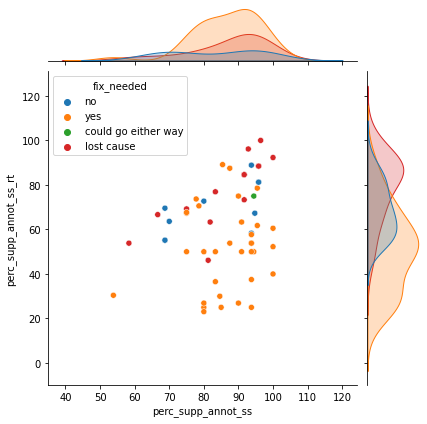

In [78]:
# percentage of supported splice sites in annotated transcripts that matched novel transcript 
#, readthrough vs. non-readthrough
sns.jointplot(df, hue='fix_needed', x='perc_supp_annot_ss', y='perc_supp_annot_ss_rt')

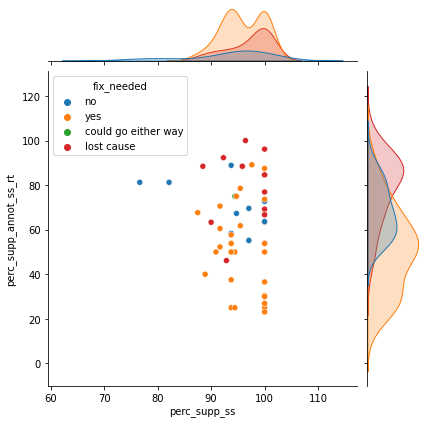

In [80]:
# percentage of supported splice sites in annotated transcripts that matched novel transcript 
#, readthrough vs. non-readthrough
sns.jointplot(df, hue='fix_needed', x='perc_supp_ss', y='perc_supp_annot_ss_rt')

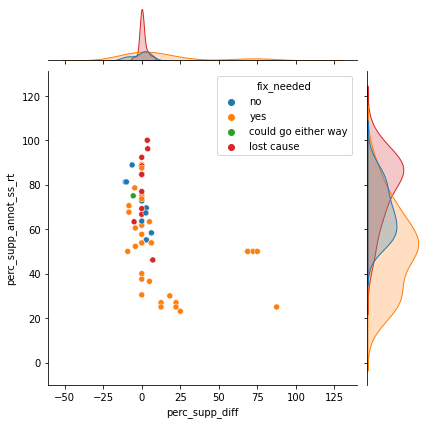

In [82]:
# percentage of supported splice sites in annotated transcripts that matched novel transcript 
# readthrough, versus difference between supported sss in rt vs. not rt
df['perc_supp_diff'] = df['perc_supp_ss']-df['perc_supp_ss_rt']
sns.jointplot(df, hue='fix_needed', x='perc_supp_diff', y='perc_supp_annot_ss_rt')

In [84]:
df.to_csv('readthrough_genes_novel_transcripts_8.tsv', sep='\t')

In [ ]:
df = pd.read_csv('readthrough_genes_novel_transcripts_8.tsv', sep='\t')
df = df.loc[df.fix_needed.isin(['yes', 'no'])]

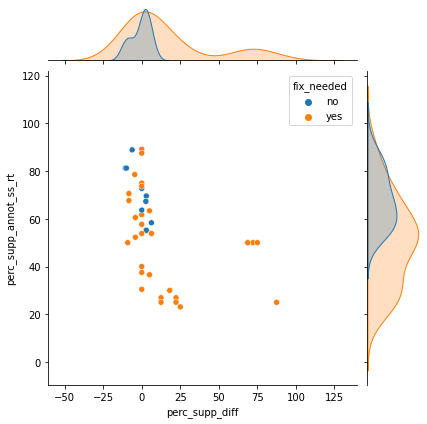

In [87]:
# percentage of supported splice sites in annotated transcripts that matched novel transcript 
# readthrough, versus difference between supported sss in rt vs. not rt
df['perc_supp_diff'] = df['perc_supp_ss']-df['perc_supp_ss_rt']
sns.jointplot(df, hue='fix_needed', x='perc_supp_diff', y='perc_supp_annot_ss_rt')

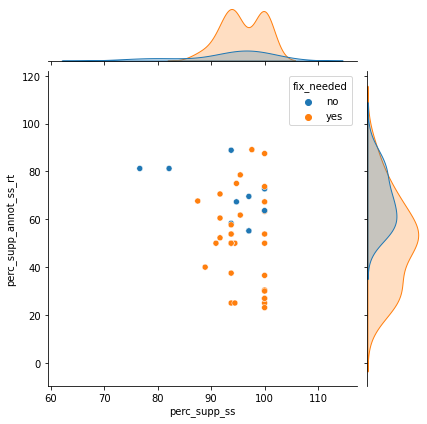

In [88]:
# percentage of supported splice sites in annotated transcripts that matched novel transcript 
#, readthrough vs. non-readthrough
sns.jointplot(df, hue='fix_needed', x='perc_supp_ss', y='perc_supp_annot_ss_rt')

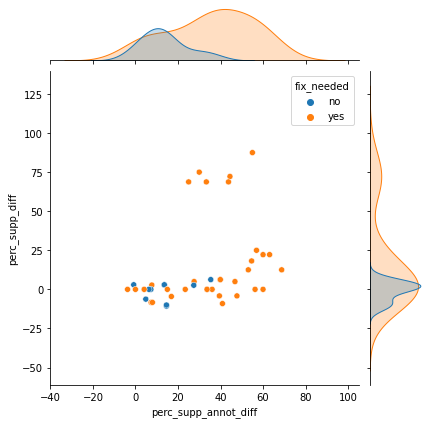

In [92]:
df['perc_supp_annot_diff'] = df['perc_supp_annot_ss']-df['perc_supp_annot_ss_rt']
sns.jointplot(df, hue='fix_needed', x='perc_supp_annot_diff', y='perc_supp_diff')

In [ ]:
df['perc_supp_annot_diff'] = df['perc_supp_annot_ss']-df['perc_supp_annot_ss_rt']
sns.jointplot(df, hue='fix_needed', x='perc_supp_annot_diff', y='perc_supp_diff')

## 231213 let's try to discriminate between the transcripts that need fixing don't

In [19]:
from sklearn.model_selection import KFold

In [5]:
df = pd.read_csv('readthrough_genes_novel_transcripts_8.tsv', sep='\t')
df = df.loc[df.fix_needed.isin(['yes', 'no'])]


In [41]:
df = pd.read_csv('readthrough_genes_novel_transcripts_8.tsv', sep='\t')
df = df.loc[df.fix_needed.isin(['yes', 'no'])]
labeled_data = labeled_data.loc[labeled_data.perc_supp_annot_ss.notnull()]


In [42]:
# labeled_data = df.loc[df.fix_needed.isin(['yes', 'no'])]
# kf = KFold(n_splits=5, shuffle=True)
# kf.get_n_splits(labeled_data)
# kf

In [43]:
# for i, (train_index, test_index) in enumerate(kf.split(labeled_data)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

In [56]:
feats = ['perc_supp_ss', 
         'perc_supp_ss_rt',
         'perc_supp_annot_ss',
         'perc_supp_annot_ss_rt']
label = 'fix_needed'
X = np.array(labeled_data[feats].values)
y_test = np.array(labeled_data[label])
print(X.shape)
print(y_test.shape)

(44, 4)
(44,)


In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier

# model = SVC()
model = DecisionTreeClassifier()
y_pred = cross_val_predict(model, X, y_test)

In [54]:
labeled_data['pred'] = y_pred

In [50]:
labeled_data[['Name', label]].groupby(label).count()

,Name
fix_needed,
no,10
yes,34


In [58]:
from sklearn.metrics import classification_report
print(classification_report(labeled_data[label].tolist(), y_pred, target_names=['yes', 'no']))

wrong_inds = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
wrong_df = labeled_data.iloc[wrong_inds]

              precision    recall  f1-score   support

         yes       0.50      0.50      0.50        10
          no       0.85      0.85      0.85        34

    accuracy                           0.77        44
   macro avg       0.68      0.68      0.68        44
weighted avg       0.77      0.77      0.77        44



In [61]:
wrong_df.head()
wrong_df.to_csv('wrong_preds.tsv', sep='\t')

In [ ]:
# TODO - add distances to tss / tes for the rt and non-rt transcripts!
# think this will work as feature!

## 231214 add TSS / TES distances to closest ones in the target genes

In [62]:
df = pd.read_csv('readthrough_genes_novel_transcripts_8.tsv', sep='\t')
# df = df.loc[df.fix_needed.isin(['yes', 'no'])]
df = df.loc[df.perc_supp_annot_ss.notnull()]



In [63]:
gtf_df = pr.read_gtf(talon_gtf, rename_attr=True).df
ref_df = pr.read_gtf(ref_gtf, rename_attr=True).df

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [65]:
gtf_df = gtf_df.loc[gtf_df.Feature=='transcript']
ref_df = ref_df.loc[ref_df.Feature=='transcript']

In [67]:
[c for c in df.columns if 'Name' in c]
c = ['Name']
temp = gtf_df.loc[gtf_df.transcript_id ==

c = ['Name_supp']

c = ['Name_rt']

['Name_supp', 'Name_supp_rt', 'Name']

In [33]:
# from sklearn.svm import SVC
# for i, (train_index, test_index) in enumerate(kf.split(labeled_data)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X, y)
# Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('svc', SVC(gamma='auto'))])

## 231209

In [138]:
df = f_ss_ic_df[['gene_id', 'Name', 'gene_id_known']].drop_duplicates().copy(deep=True)

In [139]:
# total sss / transcript from the annotated transcripts
temp = k_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique()
temp = temp.reset_index().rename({'ss_id': 'n_ss_per_t'}, axis=1)
k_ss_ic_df = k_ss_ic_df.merge(temp, how='left', on='Name')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'n_ss_per_t_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


In [140]:
# total # splice sss / transcript for obs. transcripts
temp = f_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique()
temp = temp.reset_index().rename({'ss_id': 'n_ss_per_t'}, axis=1)
df = df.merge(temp, how='left', on='Name')

In [141]:
# total # known sss / transcript for obs. transcripts
temp = f_ss_ic_df[['Name', 'ss_id', 'known']].drop_duplicates().copy(deep=True)
temp = temp.loc[temp.known==True]
temp = temp.groupby('Name').nunique()
temp = temp.reset_index().rename({'ss_id': 'n_known_ss_per_t'}, axis=1)
df = df.merge(temp, how='left', on='Name')

In [144]:
# max. # of known sss / transcript for an annotated transcript w/ gene
# for obs. transcripts
temp = f_ss_ic_df[['Name', 'ss_id', 'known', 'gene_id_known', 'Name_known']].drop_duplicates().copy(deep=True)
temp = temp.loc[temp.known==True]
temp.drop('known', axis=1, inplace=True)
temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
temp.rename({'ss_id':'n_known_s_per_t'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_known_s_per_t', ascending=False)
temp = temp.drop_duplicates(subset=['Name', 'gene_id_known'], keep='first')
temp.rename({'n_known_s_per_t':'max_ss_from_t',
             'Name_known': 'max_ss_from_t_Name'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on=['Name', 'gene_id_known'])

In [145]:
# max. # of known sss / transcript for an annotated transcript
# for obs. transcripts w/ rt genes
temp = f_ss_ic_df[['Name', 'ss_id', 'known', 'gene_id_known', 'Name_known']].drop_duplicates().copy(deep=True)
temp = temp.loc[temp.known==True]
temp = temp.loc[~temp.gene_id_known.isin(fusion_gids)]
temp.drop('known', axis=1, inplace=True)
temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
temp.rename({'ss_id':'n_known_s_per_t'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_known_s_per_t', ascending=False)
temp = temp.drop_duplicates(subset=['Name', 'gene_id_known'], keep='first')
temp.rename({'n_known_s_per_t':'max_ss_from_t_no_rt',
             'Name_known': 'max_ss_from_t_Name_no_rt'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on=['Name', 'gene_id_known'])

In [199]:
# total # known sss / transcript for annot. transcripts
temp = k_ss_ic_df[['Name', 'ss_id']].drop_duplicates().copy(deep=True)
temp = temp.groupby('Name').nunique()
temp = temp.reset_index().rename({'ss_id': 'n_ss_from_max_ss_from_t_no_rt',
                                  'Name': 'max_ss_from_t_Name_no_rt'}, axis=1)
temp.head()
# df = df.merge(temp, how='left', 
#               on='max_ss_from_t_Name_no_rt')

,max_ss_from_t_Name_no_rt,n_ss_from_max_ss_from_t_no_rt
0,ENSG00000000003_1,14
1,ENSG00000000003_2,12
2,ENSG00000000003_3,12
3,ENSG00000000003_4,10
4,ENSG00000000003_5,10


In [180]:
# total # known sss / transcript for annot. transcripts
temp = k_ss_ic_df[['Name', 'ss_id']].drop_duplicates().copy(deep=True)
temp = temp.groupby('Name').nunique()
temp = temp.reset_index().rename({'ss_id': 'n_ss_from_max_ss_from_t',
                                  'Name': 'max_ss_from_t_Name'}, axis=1)
df = df.merge(temp, how='left', 
              on='max_ss_from_t_Name')

In [146]:
# max. # of sss / gene for an annotated gene for obs transcripts
temp = f_ss_ic_df[['Name', 'ss_id', 'known', 'gene_id_known']].drop_duplicates().copy(deep=True)
temp = temp.loc[temp.known==True]
temp.drop('known', axis=1, inplace=True)
temp = temp.groupby(['Name', 'gene_id_known']).nunique().reset_index()
temp.rename({'ss_id':'n_known_s_per_g'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_known_s_per_g', ascending=False)
temp = temp.drop_duplicates(subset=['Name', 'gene_id_known'], keep='first')
temp.rename({'n_known_s_per_g':'ss_from_g'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on=['Name', 'gene_id_known'])

In [147]:
# max. # of sss / gene for an annotated gene for obs transcripts w/o rt
temp = f_ss_ic_df[['Name', 'ss_id', 'known', 'gene_id_known']].drop_duplicates().copy(deep=True)
temp = temp.loc[temp.known==True]
temp = temp.loc[~temp.gene_id_known.isin(fusion_gids)]
temp.drop('known', axis=1, inplace=True)
temp = temp.groupby(['Name', 'gene_id_known']).nunique().reset_index()
temp.rename({'ss_id':'n_known_s_per_g'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_known_s_per_g', ascending=False)
temp = temp.drop_duplicates(subset=['Name', 'gene_id_known'], keep='first')
temp.rename({'n_known_s_per_g':'ss_from_g_no_rt'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on=['Name', 'gene_id_known'])

In [148]:
# number of genes that have overlapping sss for each transcript
temp = f_ss_ic_df[['Name', 'known', 'gene_id_known']].drop_duplicates().copy(deep=True)
temp = temp.loc[temp.known==True]
temp.drop('known', axis=1, inplace=True)
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'gene_id_known': 'n_genes'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')

In [149]:
# number of genes that have overlapping sss for each transcript, w/o 
# annotated RT genes
temp = f_ss_ic_df[['Name', 'known', 'gene_id_known']].drop_duplicates().copy(deep=True)
temp = temp.loc[~temp.gene_id_known.isin(fusion_gids)]
temp = temp.loc[temp.known==True]
temp.drop('known', axis=1, inplace=True)
temp = temp.groupby('Name').nunique().reset_index()
temp.rename({'gene_id_known': 'n_genes_no_rt'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')

In [150]:
# add transcript / gene novelty from talon df
df = df.merge(talon_df[['transcript_novelty', 'gene_novelty', 'annot_transcript_id']], 
              how='left', 
              left_on='Name',
              right_on='annot_transcript_id')
df.drop('annot_transcript_id', axis=1, inplace=True)

In [181]:
# start filtering
filt_df = df.loc[df.transcript_novelty!='Known'].copy(deep=True)
filt_df = filt_df.loc[filt_df.gene_novelty=='Known'].copy(deep=True)

In [182]:
# get transcripts that change n genes when removing rt genes
filt_df = filt_df.loc[filt_df.n_genes!=filt_df.n_genes_no_rt]

In [183]:
# filter for n_genes_no_rt ==1
filt_df = filt_df.loc[(filt_df.n_genes_no_rt==1)]

In [184]:
# filter for genes where the gene we assigned it isn't the gene that we 
# intersected it with
filt_df['gid'] = cerberus.get_stable_gid(filt_df, 'gene_id')
filt_df = filt_df.loc[(filt_df.gene_id_known!=filt_df.gid)]

In [185]:
print(len(filt_df.Name.unique()))

3929


In [186]:
filt_df.head()

,gene_id,Name,gene_id_known,n_ss_per_t,n_known_ss_per_t,known,max_ss_from_t_Name,max_ss_from_t,max_ss_from_t_Name_no_rt,max_ss_from_t_no_rt,ss_from_g,ss_from_g_no_rt,n_genes,n_genes_no_rt,transcript_novelty,gene_novelty,n_ss_from_max_ss_from_t_no_rt,n_ss_from_max_ss_from_t,gid
4365,ENSG00000008128.22,TALONT000291637,ENSG00000268575,12,12.0,1.0,ENSG00000268575_1,10.0,NaN,NaN,10.0,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128
4367,ENSG00000008128.22,TALONT000291641,ENSG00000268575,12,12.0,1.0,ENSG00000268575_1,9.0,NaN,NaN,9.0,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128
4369,ENSG00000008128.22,TALONT000291742,ENSG00000268575,2,2.0,1.0,ENSG00000268575_1,2.0,NaN,NaN,2.0,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128
4371,ENSG00000008128.22,TALONT000292018,ENSG00000268575,6,6.0,1.0,ENSG00000268575_1,4.0,NaN,NaN,4.0,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128
4373,ENSG00000215790.7,TALONT000292468,ENSG00000268575,12,11.0,1.0,ENSG00000268575_1,2.0,NaN,NaN,2.0,NaN,2.0,1.0,NNC,Known,NaN,38.0,ENSG00000215790


In [197]:
tim_gene = 'ENSG00000156873'
filt_df.loc[filt_df.gene_id_known==tim_gene]

,gene_id,Name,gene_id_known,n_ss_per_t,n_known_ss_per_t,known,max_ss_from_t_Name,max_ss_from_t,max_ss_from_t_Name_no_rt,max_ss_from_t_no_rt,...,ss_from_g_no_rt,n_genes,n_genes_no_rt,transcript_novelty,gene_novelty,n_ss_from_max_ss_from_t_no_rt,n_ss_from_max_ss_from_t,gid,perc_ss_from_t,perc_ss_from_t_no_rt
70683,ENSG00000260899.1,TALONT000637494,ENSG00000156873,18,18.0,1.0,ENSG00000156873_1,17.0,ENSG00000156873_1,17.0,...,18.0,2.0,1.0,ISM,Known,18.0,18.0,ENSG00000260899,94.444444,94.444444
70685,ENSG00000260899.1,TALONT000637495,ENSG00000156873,14,14.0,1.0,ENSG00000156873_1,14.0,ENSG00000156873_1,14.0,...,14.0,2.0,1.0,ISM,Known,18.0,18.0,ENSG00000260899,100.000000,100.000000
70687,ENSG00000260899.1,TALONT000637497,ENSG00000156873,16,15.0,1.0,ENSG00000156873_1,15.0,ENSG00000156873_3,15.0,...,15.0,2.0,1.0,ISM,Known,20.0,18.0,ENSG00000260899,93.750000,93.750000
70690,ENSG00000260899.1,TALONT000637508,ENSG00000156873,16,16.0,1.0,ENSG00000156873_5,15.0,ENSG00000156873_3,15.0,...,16.0,2.0,1.0,NIC,Known,20.0,16.0,ENSG00000260899,93.750000,93.750000
70692,ENSG00000260899.1,TALONT000637511,ENSG00000156873,16,16.0,1.0,ENSG00000156873_3,16.0,ENSG00000156873_1,16.0,...,16.0,2.0,1.0,ISM,Known,18.0,20.0,ENSG00000260899,100.000000,100.000000
70694,ENSG00000260899.1,TALONT000637622,ENSG00000156873,10,10.0,1.0,ENSG00000156873_2,10.0,ENSG00000156873_2,10.0,...,10.0,2.0,1.0,ISM,Known,18.0,18.0,ENSG00000260899,100.000000,100.000000
70696,ENSG00000260899.1,TALONT000637792,ENSG00000156873,16,16.0,1.0,ENSG00000156873_3,15.0,ENSG00000156873_3,15.0,...,16.0,2.0,1.0,ISM,Known,20.0,20.0,ENSG00000260899,93.750000,93.750000
70698,ENSG00000260899.1,TALONT000638355,ENSG00000156873,16,16.0,1.0,ENSG00000156873_3,16.0,ENSG00000156873_1,16.0,...,16.0,2.0,1.0,ISM,Known,18.0,20.0,ENSG00000260899,100.000000,100.000000


In [192]:
filt_df['perc_ss_from_t'] = (filt_df.max_ss_from_t/filt_df.n_ss_per_t)*100
filt_df['perc_ss_from_t_no_rt'] = (filt_df.max_ss_from_t_no_rt/filt_df.n_ss_per_t)*100

In [198]:
# filt_df.loc[(filt_df.perc_ss_from_t!=filt_df.perc_ss_from_t_no_rt)&(filt_df.perc_ss_from_t_no_rt.notnull())]
# filt_df.loc[filt_df.max_ss_from_t!=filt_df.max_ss_from_t_no_rt].head()
# ah, this is because it's still on the level of transcript + gene for each column,
# need to reduce just to transcript

,gene_id,Name,gene_id_known,n_ss_per_t,n_known_ss_per_t,known,max_ss_from_t_Name,max_ss_from_t,max_ss_from_t_Name_no_rt,max_ss_from_t_no_rt,...,ss_from_g_no_rt,n_genes,n_genes_no_rt,transcript_novelty,gene_novelty,n_ss_from_max_ss_from_t_no_rt,n_ss_from_max_ss_from_t,gid,perc_ss_from_t,perc_ss_from_t_no_rt
4365,ENSG00000008128.22,TALONT000291637,ENSG00000268575,12,12.0,1.0,ENSG00000268575_1,10.0,NaN,NaN,...,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128,83.333333,NaN
4367,ENSG00000008128.22,TALONT000291641,ENSG00000268575,12,12.0,1.0,ENSG00000268575_1,9.0,NaN,NaN,...,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128,75.000000,NaN
4369,ENSG00000008128.22,TALONT000291742,ENSG00000268575,2,2.0,1.0,ENSG00000268575_1,2.0,NaN,NaN,...,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128,100.000000,NaN
4371,ENSG00000008128.22,TALONT000292018,ENSG00000268575,6,6.0,1.0,ENSG00000268575_1,4.0,NaN,NaN,...,NaN,2.0,1.0,ISM,Known,NaN,38.0,ENSG00000008128,66.666667,NaN
4373,ENSG00000215790.7,TALONT000292468,ENSG00000268575,12,11.0,1.0,ENSG00000268575_1,2.0,NaN,NaN,...,NaN,2.0,1.0,NNC,Known,NaN,38.0,ENSG00000215790,16.666667,NaN


In [ ]:
temp = filt_df.loc[filt_df

In [ ]:
# are there any sss that are uniquely supported by rt gene?